In [465]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
import json
from igraph import Graph, Layout
import math, copy, pdb
from collections import defaultdict

In [416]:
class node:
    def __init__(self, name, coord):
        self.name = name
        self.coord = coord

In [124]:
def read_coordinates(filePath):
    address = []
    nodes = []
    coordLookup = defaultdict(dict)
    with open(filePath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip('\n').split('\t')
            name = data[0]
            address.append(data[1])
            nodes.append([float(data[-2]), float(data[-1])])
            coordLookup[name]['address'] = data[1]
            coordLookup[name]['coord'] = [float(data[-2]), float(data[-1])]
    return address, nodes, coordLookup

In [392]:
def create_Uber_Graph(filename):
    uberGraph = Graph.Read_Ncol(filename, names=True, directed=False)
    uberGraph.simplify(combine_edges='mean')
    clusters = uberGraph.decompose()
    return clusters[0]

In [126]:
def road_mesh(points, tri):
    points = np.array(points)
    plt.figure(figsize=(12,12))
    plt.triplot(points[:,0], points[:,1], tri.simplices)
    plt.plot(points[:,0], points[:,1], 'o', ms=2)
    #plt.axis([-123,-121.5,37,38.5])
    plt.show()

In [435]:
def create_Gdelta(afterDeletionNodes, originalNodes, tri):
    indptr, indices = tri.vertex_neighbor_vertices
    npoints = len(afterDeletionNodes)
    with open('roadmesh.txt', 'w') as f:
        for k in range(npoints):
            adj = indices[indptr[k]:indptr[k+1]]
            for adjPts in adj:
                f.write('{} {}\n'.format(originalNodes[k].name, originalNodes[adjPts].name))
                #f.write('{} {}\n'.format(k+1, adjPts+1))
    G_delta = Graph.Read_Ncol('roadmesh.txt', names=True, directed=False)
    G_delta.simplify()
    return G_delta

In [504]:
def plotgraph(graph, coordLookup):
    x = []
    y = []
    plt.figure(figsize=(12,12))
    for e in graph.es:
        v0, v1 = e.tuple
        n0, n1 = graph.vs['name'][v0], graph.vs['name'][v1]
        coord0 = coordLookup[n0]['coord']
        coord1 = coordLookup[n1]['coord']
        x.append(coord0[0])
        x.append(coord1[0])
        y.append(coord0[1])
        y.append(coord1[1])
    for i in np.arange(0,len(x),2):
        plt.plot(x[i:i+2],y[i:i+2],'b-',linewidth=0.5)
    plt.plot(-122.1759822222222, 37.42968588888888, 'go')
    plt.plot(-122.06456181081083, 36.97416881081081, 'ro')
    plt.axis([-122.4,-121.9,36.8,37.5])#zoom in school
    #plt.axis([-123,-121.5,37,38.5])#zoom in bay area
#     plt.plot([-122.475, -122.479], [37.806, 37.83], 'r-', linewidth=1.5)
#     plt.plot([-122.501, -122.387], [37.956, 37.93], 'r-', linewidth=1.5)
#     plt.plot([-122.273, -122.122], [37.563, 37.627], 'r-', linewidth=1.5)
#     plt.plot([-122.142, -122.067], [37.486, 37.54], 'r-', linewidth=1.5)
#     plt.plot([-122.388, -122.302], [37.788, 37.825], 'r-', linewidth=1.5)
    plt.show()

In [491]:
def remove_fake_bridge(G_delta, uberGraph, thres):
    G_copy = copy.deepcopy(G_delta)
    counter = 0
    remove_counter = 0
    toBeDeleted = []
    for e in G_copy.es:
        counter += 1
        if counter%1000 == 0:
            print(counter)
            print(remove_counter)
            
        time_G = e['distances']/0.01
        v0, v1 = e.tuple
        n0, n1 = G_copy.vs['name'][v0], G_copy.vs['name'][v1]
        
        rv0 = uberGraph.vs.find(name=n0).index
        rv1 = uberGraph.vs.find(name=n1).index
        realEdge = uberGraph.es.select(_source=rv0, _target=rv1)
        if not realEdge:
            time_U = uberGraph.shortest_paths_dijkstra(rv0, target=rv1, weights='weight', mode='OUT')[0][0]
        else:
            time_U = realEdge['weight'][0]
        #if time_U < float('inf') and (time_U-time_G)/time_U >= thres:
        if time_U > 1000:
            toBeDeleted.append((v0, v1))
            remove_counter += 1
        #pdb.set_trace()
    G_copy.delete_edges(toBeDeleted)
    return G_copy

In [440]:
def associate_distance_flowrate(G_delta, uberGraph, coordLookup):
    distances = []
    flowrates = []
    for e in G_delta.es:
        v0, v1 = e.tuple
        n0, n1 = G_delta.vs['name'][v0], G_delta.vs['name'][v1]

        long0, lat0 = coordLookup[n0]['coord']
        long1, lat1 = coordLookup[n1]['coord']
        di = math.sqrt((69*abs(long0-long1))**2 + (69*abs(lat0-lat1))**2)
        distances.append(di)

        if n0 not in uberGraph.vs['name'] or n1 not in uberGraph.vs['name']:
            flowrates.append(0)
            continue

        source = uberGraph.vs.find(name=n0).index
        target = uberGraph.vs.find(name=n1).index
        time = uberGraph.shortest_paths_dijkstra(source, target=target, weights='weight', mode='OUT')[0][0]

        f = 4 * 3600/(0.003/(di/time) + 2)
        flowrates.append(f)

    G_delta.es['distances'] = distances
    G_delta.es['flowrates'] = flowrates
    return G_delta

In [238]:
stanford_v = G_delta.vs.find(name='2607')
ucsc_v = G_delta.vs.find(name='1968')
G_delta.get_shortest_paths(stanford_v, ucsc_v, weights='distances', mode='OUT', output='vpath')

[[2652, 2649, 2326, 2321, 2324, 2482, 2663, 1214, 2332]]

In [240]:
G_delta.edge_disjoint_paths(source=stanford_v.index, target=ucsc_v.index)

5

In [246]:
plot_roadmesh(G_delta)

In [116]:
uberGraph = Graph.Read_Ncol('edge_list.txt', names=True, directed=False)

In [121]:
uberGraph.simplify(combine_edges='mean')

## Question 11

In [429]:
uberGraph = create_Uber_Graph('edge_list.txt')

In [430]:
address, nodes, coordLookup = read_coordinates('json.txt')

In [431]:
toBeDeleted = []
nameList = uberGraph.vs['name']
originalNodes = [node(i+1, nodes[i]) for i in range(len(nodes))]
for i in range(len(nodes)):
    if str(i+1) not in nameList:
        toBeDeleted.append(i)
for i in toBeDeleted[::-1]:
    del originalNodes[i]

In [432]:
len(originalNodes)

1880

In [433]:
afterDeletionNodes = [n.coord for n in originalNodes]
tri = Delaunay(afterDeletionNodes)

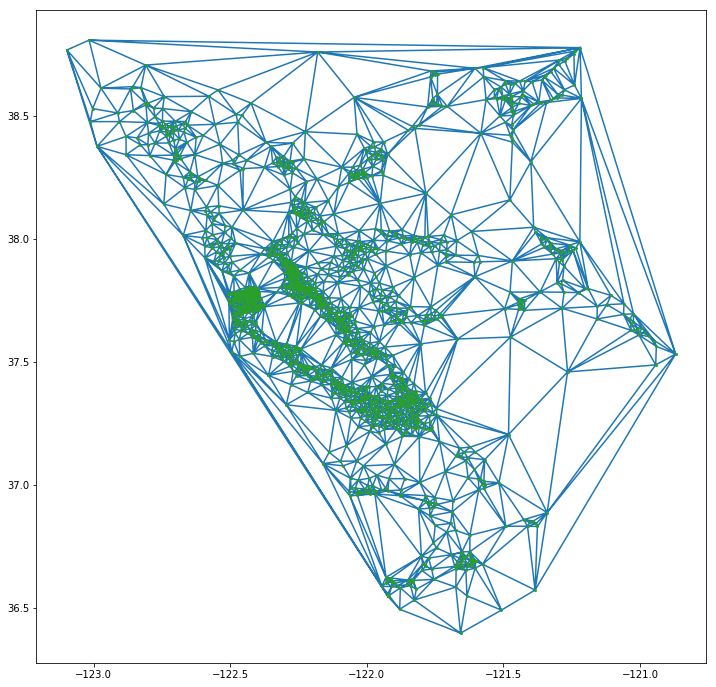

In [434]:
road_mesh(afterDeletionNodes, tri)

In [436]:
G_delta = create_Gdelta(afterDeletionNodes, originalNodes, tri)

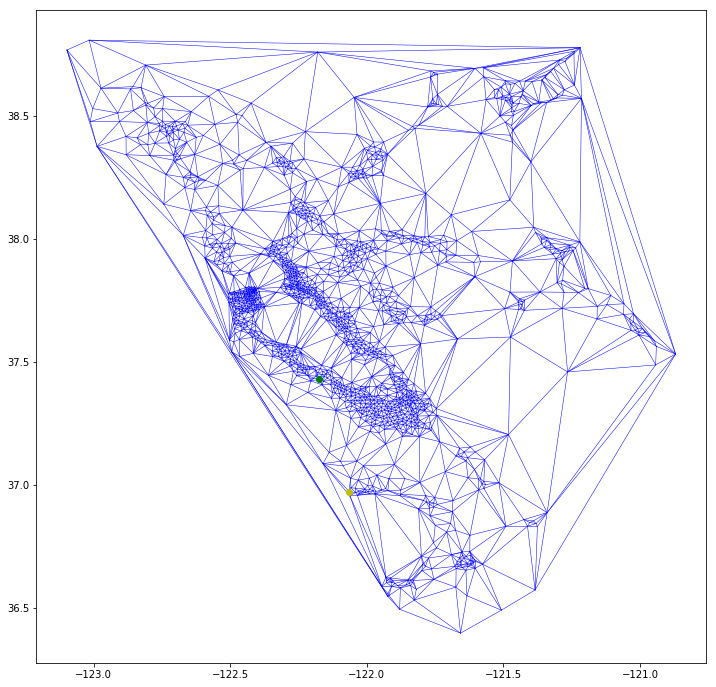

In [453]:
plotgraph(G_delta, coordLookup)

## Question 12

In [438]:
G_delta.vcount()

1880

In [439]:
G_delta.ecount()

5627

In [441]:
G_delta = associate_distance_flowrate(G_delta, uberGraph, coordLookup)

## Question 13

In [506]:
def max_flow(graph, src_addr, dest_addr, address):
    result = 0
    s = str(address.index(src_addr)+1)
    d = str(address.index(dest_addr)+1)
    src = graph.vs.find(name=s)
    dest = graph.vs.find(name=d)
    flow = graph.maxflow(src.index, dest.index, 'flowrates')
    maxFlow = graph.maxflow_value(src.index, dest.index, capacity=[i/2 for i in graph.es['flowrates']])
    for e in flow.es:
        print(e['flowrates'])
        result += e['flowrates']
    return flow, maxFlow, result

In [507]:
flow, maxFlow, result = max_flow(G_delta, '100 Campus Drive, Stanford', '700 Meder Street, Santa Cruz', address)

5757.6328638152045
6092.883874609618
5860.136323076119
5515.897797255106
6803.3710258441615


In [509]:
maxFlow

15014.960942300106

In [449]:
stanford_v = G_delta.vs.find(name='2607')
ucsc_v = G_delta.vs.find(name='1968')
G_delta.get_shortest_paths(stanford_v, ucsc_v, weights='distances', mode='OUT', output='vpath')

[[1835, 1832, 1607, 1602, 1606, 1705, 1839, 863, 1613]]

In [450]:
G_delta.shortest_paths_dijkstra(stanford_v.index, ucsc_v.index, weights='distances', mode='OUT')

[[33.75513681570652]]

In [456]:
G_delta.edge_disjoint_paths(source=stanford_v.index, target=ucsc_v.index)

5

## Question 14

In [492]:
G_noFakeBridge = remove_fake_bridge(G_delta, uberGraph, 0.3)

1000
88
2000
131
3000
161
4000
197
5000
225


In [494]:
G_noFakeBridge.ecount()

5368

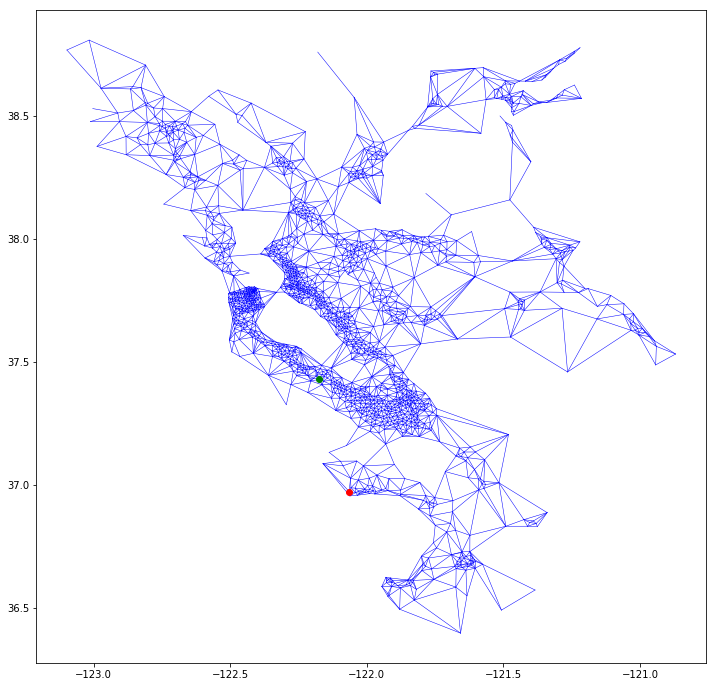

In [495]:
plotgraph(G_noFakeBridge, coordLookup)

## Question 15

In [502]:
flow_noBridge, maxFlow_noBridge, result_noBridge= max_flow(G_noFakeBridge, '100 Campus Drive, Stanford', '700 Meder Street, Santa Cruz', address)

5757.6328638152045
6092.883874609618
5860.136323076119
5515.897797255106
6803.3710258441615


In [503]:
result_noBridge

30029.921884600208

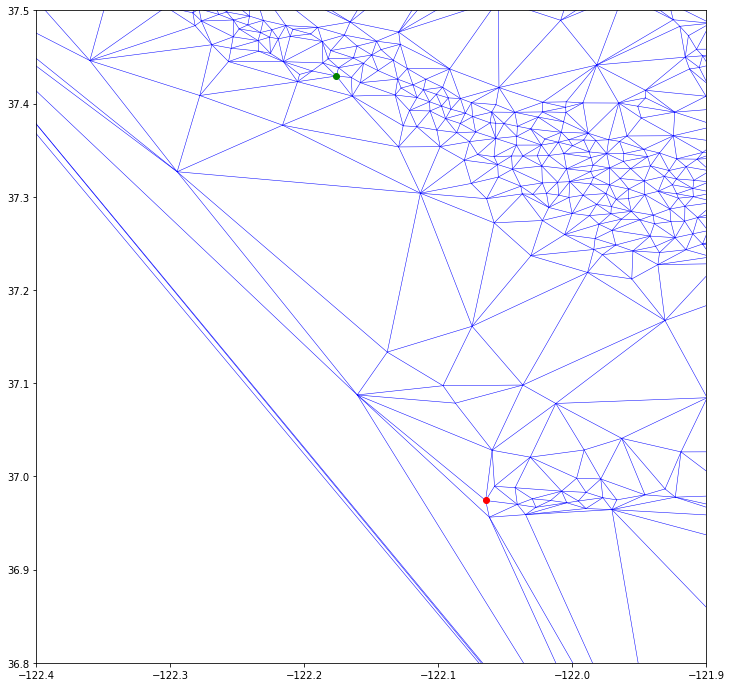

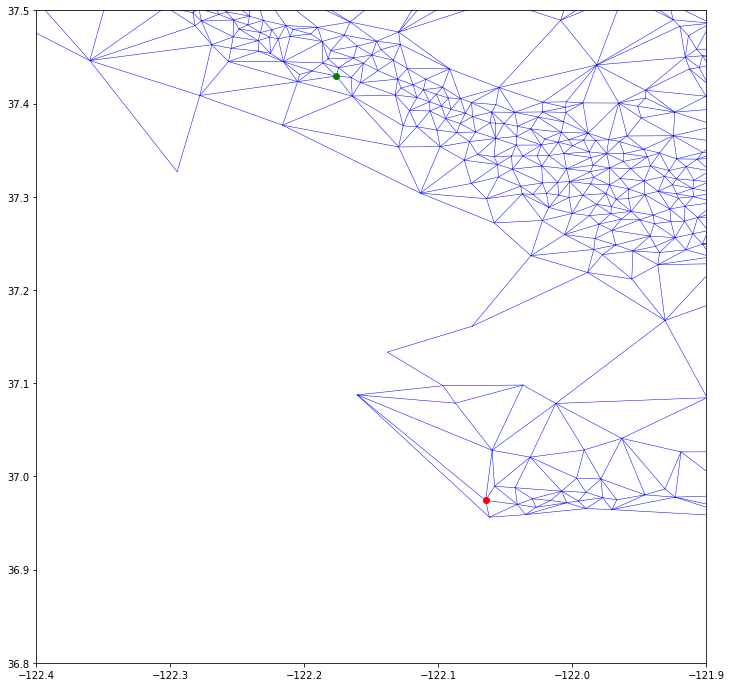

In [505]:
plotgraph(G_delta, coordLookup)
plotgraph(G_noFakeBridge, coordLookup)

In [457]:
G_noFakeBridge.edge_disjoint_paths(source=stanford_v.index, target=ucsc_v.index)

3

## Testing

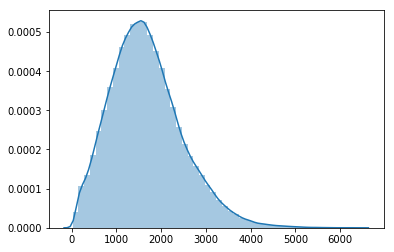

In [361]:
import seaborn as sns
sns.distplot(uberGraph.es['weight']);

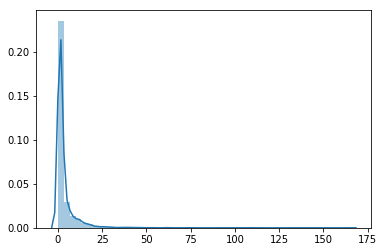

In [364]:
sns.distplot(G_delta.es['distances'])

In [373]:
uberGraph.vcount()

1887

In [374]:
clusters = uberGraph.decompose()

In [375]:
clusters

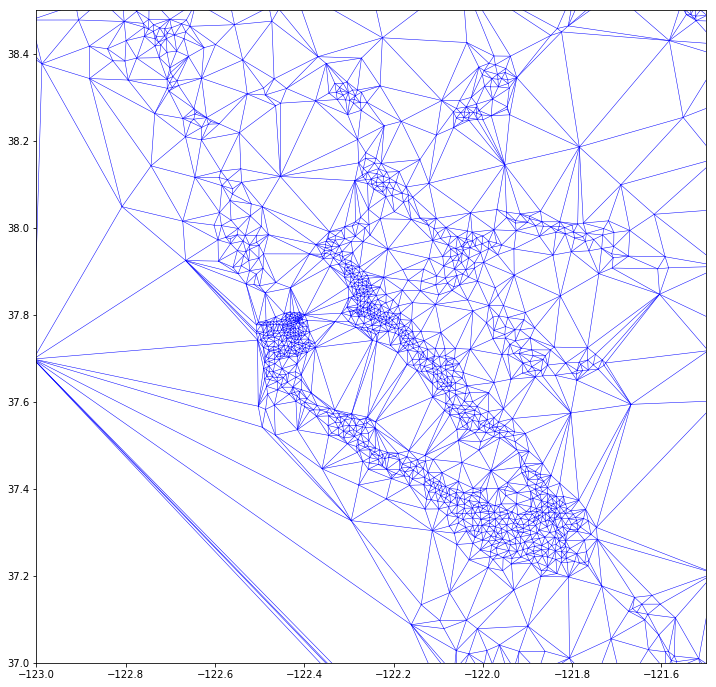

In [389]:
plotgraph(G_delta, coordLookup)

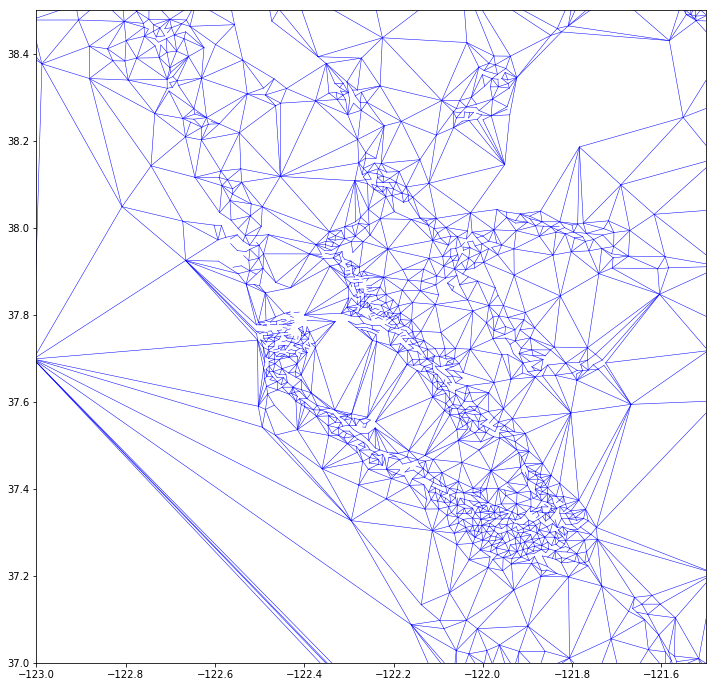

In [390]:
plotgraph(G_noFakeBridge, coordLookup)